In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/emaize


In [3]:
import h5py

In [4]:
from pysnptools.snpreader import SnpData, Pheno, SnpReader
from pysnptools.kernelreader import KernelData, KernelReader

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [5]:
import pandas as pd

In [6]:
phenotypes = pd.read_table('emaize_data/phenotype/pheno_emaize.txt')

In [7]:
import os
if not os.path.exists('output/fastlmm'):
    os.mkdir('output/fastlmm')

In [8]:
# create phenotype file
df_pheno = phenotypes[phenotypes['type'] == 'training'].copy()
df_pheno['fid'] = df_pheno['id']
df_pheno['iid'] = df_pheno['id']
traits = ('trait1', 'trait2', 'trait3')
for trait in traits:
    df_pheno[['fid', 'iid', trait]].to_csv('output/fastlmm/pheno_%s.txt'%trait, index=False, sep='\t', header=False)

In [9]:
phenotypes.head()

,type,id,pedigree,trait1,trait2,trait3
0,training,L0001,f1_X_m1,-1.746103,-0.785525,-0.331637
1,training,L0002,f2_X_m1,-1.679248,-1.569490,-2.572614
2,training,L0003,f3_X_m1,-2.748920,-0.608644,-1.108812
3,training,L0004,f4_X_m1,-2.414647,-0.672045,-1.315051
4,training,L0005,f5_X_m1,-1.879812,-0.740913,-1.879181


In [10]:
pheno = {}
for trait in traits:
    pheno[trait] = Pheno('output/fastlmm/pheno_%s.txt'%trait)

In [11]:
index_training = np.nonzero((phenotypes['type'] == 'training').values)[0]
index_test = np.nonzero((phenotypes['type'] == 'test').values)[0]

In [76]:
# read SNPs
iid = [[name, name] for name in phenotypes['id']]
with h5py.File('output/random_select/10000', 'r') as f:
    X = f['/0/X'][:]
    index_not_constant = np.nonzero(X[:, index_training].std(axis=1) > 0.15)[0]
    np.random.shuffle(index_not_constant)
    X = np.take(X, index_not_constant, axis=0)
    X = X*(0.001*np.random.normal(size=X.shape) + np.ones_like(X))
    position = f['/0/position'][:][index_not_constant]
    chrom = f['/0/chrom'][:][index_not_constant]
    pos = np.vstack([chrom, np.zeros(position.shape[0]), position]).T
    print(X.shape, position.shape, chrom.shape, pos.shape)
    test_snps = SnpData(iid=iid, sid=position.astype('S'), 
                        val=X.T.astype('float32'), pos=pos)
    del X
    
    X = f['/1/X'][:]
    X = X*(0.001*np.random.normal(size=X.shape) + np.ones_like(X))
    position = f['/1/position'][:]
    chrom = f['/1/chrom'][:]
    pos = np.vstack([chrom, np.zeros(position.shape[0]), chrom]).T
    K0 = SnpData(iid=iid, sid=position.astype('S'), 
                val=X.T.astype('float32'), pos=pos)
    del X

((8299, 6210), (8299,), (8299,), (8299, 3))


In [13]:
import fastlmm
from fastlmm.association import single_snp

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
results_df = single_snp(test_snps, pheno['trait1'], K0=K0, count_A1=True)

Setting GB_goal to 1.72667617691 GB
reading 8481 SNPs in blocks of 4754 and adding up kernels (for 4754 individuals)
read 9508 SNPs in 1.61 seconds
1.61 seconds elapsed
h2=0.87284450169
time=0.945140838623
Setting GB_goal to 1.72667617691 GB
reading 8850 SNPs in blocks of 4754 and adding up kernels (for 4754 individuals)
read 9508 SNPs in 1.62 seconds
1.62 seconds elapsed
h2=0.870415018936
time=0.830221891403
Setting GB_goal to 1.72667617691 GB
reading 8842 SNPs in blocks of 4754 and adding up kernels (for 4754 individuals)
read 9508 SNPs in 1.65 seconds
1.65 seconds elapsed
h2=0.869697223967
time=0.812631130219
Setting GB_goal to 1.72667617691 GB
reading 8717 SNPs in blocks of 4754 and adding up kernels (for 4754 individuals)
read 9508 SNPs in 1.64 seconds
1.64 seconds elapsed
h2=0.871068680912
time=0.857342004776
Setting GB_goal to 1.72667617691 GB
reading 8967 SNPs in blocks of 4754 and adding up kernels (for 4754 individuals)
read 9508 SNPs in 1.66 seconds
1.66 seconds elapsed
h2=0

In [22]:
results_df.head(20)

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,810,146166287,4.0,0.0,146166287.0,1.609390e-13,0.429400,0.058032,0.106726,0.0,0.871069
1,431,15570920,5.0,0.0,15570920.0,1.733038e-13,0.450568,0.060975,0.106584,0.0,0.869830
2,469,143841402,3.0,0.0,143841402.0,5.639213e-13,0.481708,0.066635,0.104296,0.0,0.869697
3,31,88295314,8.0,0.0,88295314.0,7.867601e-13,0.479956,0.066816,0.103642,0.0,0.869655
4,108,114450128,3.0,0.0,114450128.0,2.382685e-11,-0.439168,0.065582,0.096687,0.0,0.869697
5,200,237063072,4.0,0.0,237063072.0,1.655766e-10,0.398262,0.062186,0.092507,0.0,0.871069
6,1124,240946976,1.0,0.0,240946976.0,3.291811e-10,0.407370,0.064685,0.090980,0.0,0.872845
7,516,165690403,6.0,0.0,165690403.0,9.103300e-10,0.376327,0.061323,0.088673,0.0,0.871440
8,115,80443530,5.0,0.0,80443530.0,9.235085e-10,0.373755,0.060927,0.088640,0.0,0.869830
9,522,118280471,9.0,0.0,118280471.0,1.258429e-09,0.350430,0.057592,0.087926,0.0,0.871946


In [90]:
np.repeat(phenotypes['id'].values.astype('S')[:, np.newaxis], 2, axis=1)

array([['L0001', 'L0001'],
       ['L0002', 'L0002'],
       ['L0003', 'L0003'],
       ..., 
       ['L6208', 'L6208'],
       ['L6209', 'L6209'],
       ['L6210', 'L6210']],
      dtype='|S5')

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


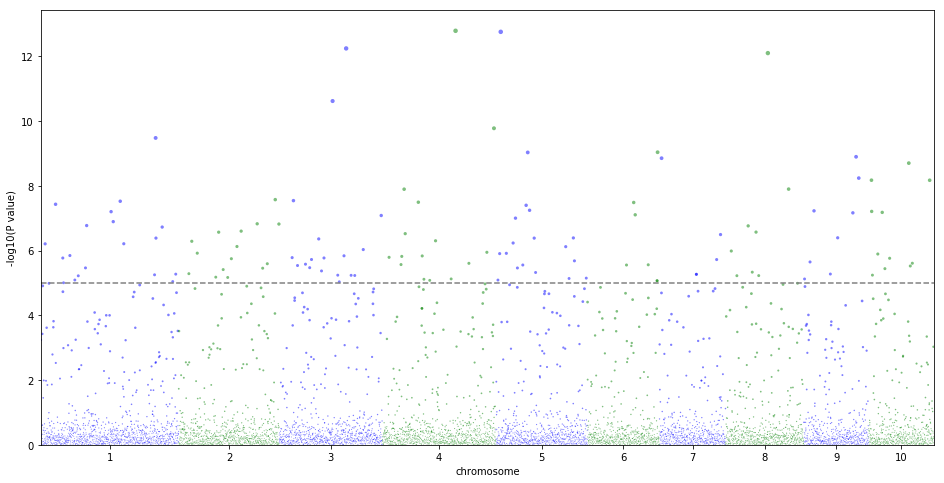

In [24]:
# Manhattan plot
import fastlmm.util.util as flutil
plt.subplots(figsize=(16, 8))
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False)

In [26]:
np.sum(results_df['PValue'] < 1e-5)

124

In [27]:
X_sig = test_snps.read()[:, results_df.query('PValue < 1e-5')['sid_index'].values].read().val

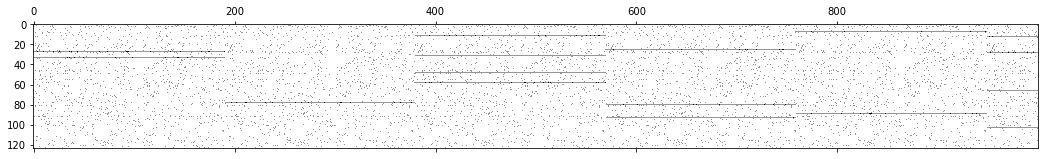

In [28]:
fig, ax = plt.subplots(figsize=(18, 15))
ax.matshow(X_sig[:1000, :].T, cmap=cm.Greys)

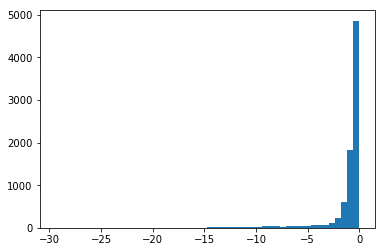

In [29]:
h = hist(np.log(results_df['PValue'].values), bins=50)

In [77]:
model = FastLMM(GB_goal=2)
model.fit(X=test_snps[index_training, :][:, :200], y=pheno['trait1'], K0_train=K0)

reading 10000 SNPs in blocks of 5661 and adding up kernels (for 4754 individuals)
read 11322 SNPs in 1.59 seconds
1.59 seconds elapsed


In [95]:
model.h2raw

0.9

In [101]:
pheno['trait1']

Pheno('output/fastlmm/pheno_trait1.txt')

In [93]:
from fastlmm.inference import FastLMM
y_mean = {}
y_var = {}
n_snps = 100
for trait in traits:
    fastlmm = FastLMM(GB_goal=2)
    #index_not_constant = np.nonzero(test_snps[index_training, :].read().val.std(axis=0) > 0.01)[0]
    print('fit %s'%trait)
    fastlmm.fit(X=test_snps[index_training, :][:, :n_snps], y=pheno[trait], K0_train=K0)

    print('predict %s'%trait)
    y_mean[trait], y_var[trait] = fastlmm.predict(X=test_snps[index_test, :][:, :n_snps],
                                       K0_whole_test=K0[index_test, :])
    del fastlmm

fit trait1
reading 10000 SNPs in blocks of 5661 and adding up kernels (for 4754 individuals)
read 11322 SNPs in 1.58 seconds
1.58 seconds elapsed
predict trait1
read 11322 SNPs in 1.25 seconds
reading 10000 SNPs in blocks of 5661 and adding up kernels (for 1456 individuals)
0.26 seconds elapsed
fit trait2
reading 10000 SNPs in blocks of 5661 and adding up kernels (for 4754 individuals)
read 11322 SNPs in 1.67 seconds
1.67 seconds elapsed
predict trait2
read 11322 SNPs in 1.25 seconds
reading 10000 SNPs in blocks of 5661 and adding up kernels (for 1456 individuals)
0.24 seconds elapsed
fit trait3
reading 10000 SNPs in blocks of 5661 and adding up kernels (for 4754 individuals)
read 11322 SNPs in 1.62 seconds
1.62 seconds elapsed
predict trait3
read 11322 SNPs in 1.23 seconds
reading 10000 SNPs in blocks of 5661 and adding up kernels (for 1456 individuals)
0.26 seconds elapsed


In [86]:
X_train = test_snps[index_training, :].read().val
X_train = X_train * (0.000001*np.random.normal(size=X_train.shape) + np.ones_like(X_train))
XX = np.dot(X_train[:, :1000].T, X_train[:, :1000])
Sxx, Uxx = np.linalg.eigh(XX)

In [87]:
Sxx.min()

1.8611480735849665e-09

In [31]:
def generate_parent_table(phenotype_file):
    phenotypes = pd.read_table(phenotype_file)
    pedigree = phenotypes['pedigree'].str.split('_', expand=True)
    pedigree.columns = ['f', 'X', 'm']
    phenotypes = pd.concat([phenotypes, pedigree], axis=1)
    phenotypes['number'] = np.arange(phenotypes.shape[0])
    parent_table = phenotypes.pivot_table(values='number', index=['m'], columns=['f'], dropna=False)
    male_ids = ['m%d' % i for i in range(1, parent_table.shape[0] + 1)]
    female_ids = ['f%d' % i for i in range(1, parent_table.shape[1] + 1)]
    parent_table = parent_table.loc[male_ids, female_ids]
    return parent_table
phenotype_file = 'emaize_data/phenotype/pheno_emaize.txt'
parent_table = generate_parent_table(phenotype_file)

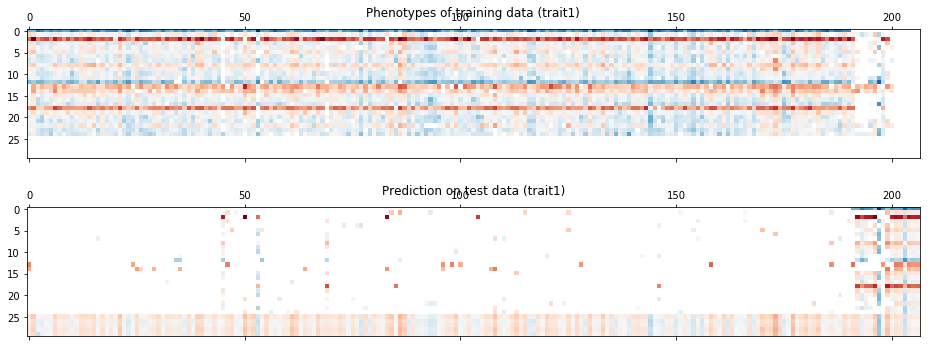

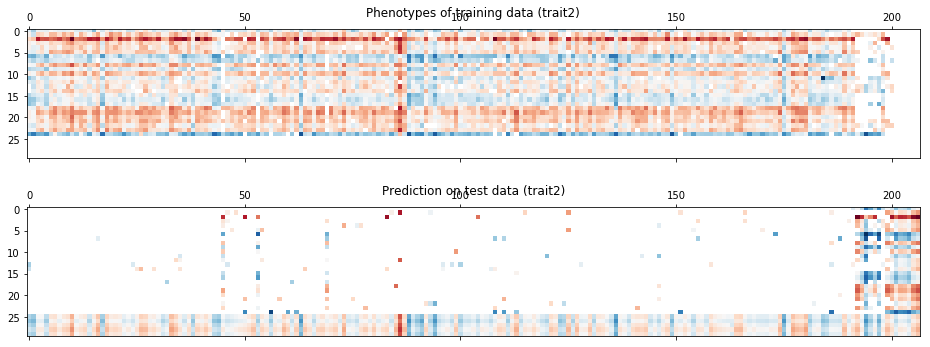

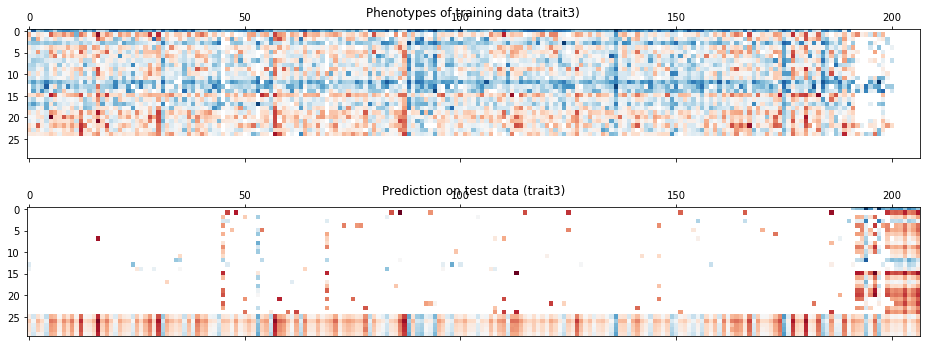

In [94]:
def normalize_phenotype(x, range_pheno=4.0):
    return (np.clip(x, -range_pheno, range_pheno) + range_pheno)/2.0/range_pheno
for trait in traits:
    pred_matrix = np.full(phenotypes.shape[0], np.nan)
    pred_matrix[index_test] = np.ravel(normalize_phenotype(y_mean[trait].val))
    pred_matrix = np.take(pred_matrix, parent_table)

    fig, ax = subplots(2, 1, figsize=(16, 6))
    ax[0].matshow(np.take(np.ravel(normalize_phenotype(phenotypes[trait].values)), parent_table), cmap=cm.RdBu_r)
    ax[0].set_title('Phenotypes of training data (%s)'%trait)

    ax[1].matshow(pred_matrix, cmap=cm.RdBu_r)
    ax[1].set_title('Prediction on test data (%s)'%trait)

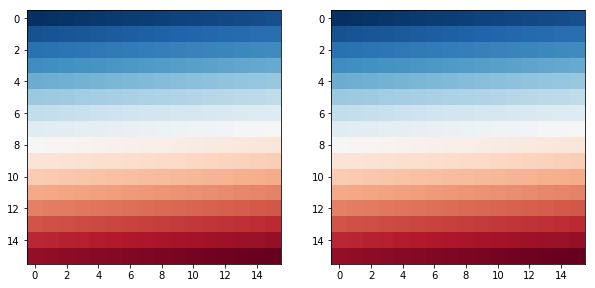

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cm.RdBu_r(np.arange(256).reshape(16, 16)))
ax[1].imshow(cm.RdBu_r(np.linspace(0, 1, 256).reshape(16, 16)))

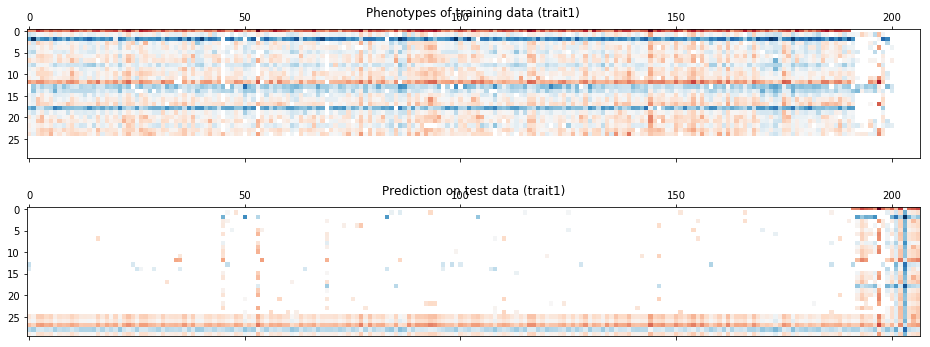

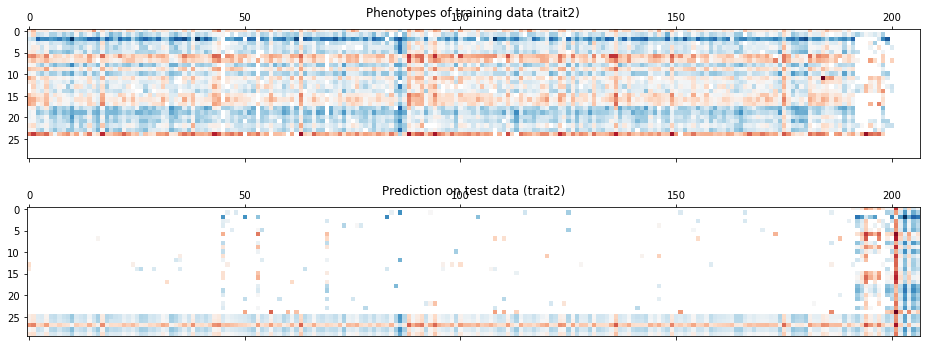

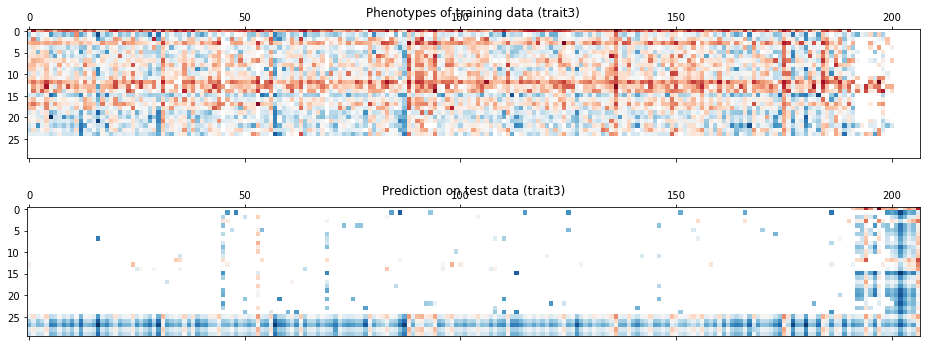

In [128]:
for trait in traits:
    pred_matrix = np.full(phenotypes.shape[0], np.nan)
    pred_matrix[index_test] = np.ravel(y_mean[trait].val)
    pred_matrix = np.take(pred_matrix, parent_table)

    fig, ax = subplots(2, 1, figsize=(16, 6))
    ax[0].matshow(np.take(np.ravel(phenotypes[trait].values), parent_table), cmap=cm.RdBu)
    ax[0].set_title('Phenotypes of training data (%s)'%trait)

    ax[1].matshow(pred_matrix, cmap=cm.RdBu)
    ax[1].set_title('Prediction on test data (%s)'%trait)

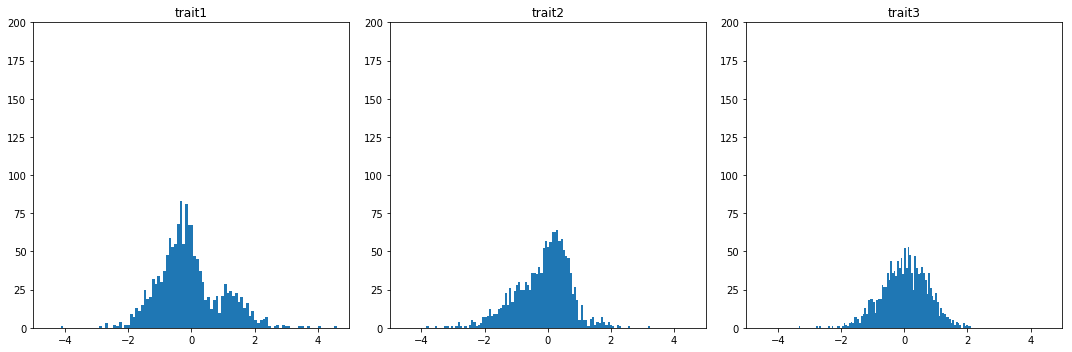

In [138]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, trait in enumerate(traits):
    h = ax[i].hist(np.ravel(y_mean[trait].val), bins=100)
    ax[i].set_title(trait)
    ax[i].set_xlim(-5, 5)
    ax[i].set_ylim(0, 200)
plt.tight_layout()

In [ ]:
scatter(pheno.read().val, mean.val, s=3)

In [57]:
from scipy.stats import pearsonr

In [58]:
pearsonr(pheno.read().val, mean.val)

(array([ 0.95954004]), array([ 0.]))

In [41]:
(results_df['PValue'] < 1e-5).sum()

124

In [35]:
results_df.shape[0]

10000